In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

Using TensorFlow backend.


In [4]:
train = pd.read_csv('wrangled_data/training_post_wrangle.csv')

test_full = pd.read_csv('wrangled_data/testing_post_wrangle.csv')

test = test_full.loc[:,['ID', 'shop_id', 'item_id']]

In [5]:
df = pd.merge(test, train, on = ['item_id','shop_id'],how = 'left')

In [6]:
dataset = train.pivot_table(index = ['shop_id','item_id'], values = ['item_cnt_month'], columns =['date_block_num'], aggfunc='sum')

In [7]:
dataset.head(3)

item_cnt_month                                                \
date_block_num            0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0    
shop_id item_id                                                                
0       30                 0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31                 0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32                 6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                 ...                                                    
date_block_num   ... 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
shop_id item_id  ...                                                    
0       30       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 34 columns]

In [8]:
dataset.reset_index(inplace = True)

In [9]:
dataset = pd.merge(test, dataset, on = ['item_id','shop_id'], how='left')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [10]:
dataset.head()

,ID,shop_id,item_id,"(item_cnt_month, 0.0)","(item_cnt_month, 1.0)","(item_cnt_month, 2.0)","(item_cnt_month, 3.0)","(item_cnt_month, 4.0)","(item_cnt_month, 5.0)","(item_cnt_month, 6.0)",...,"(item_cnt_month, 24.0)","(item_cnt_month, 25.0)","(item_cnt_month, 26.0)","(item_cnt_month, 27.0)","(item_cnt_month, 28.0)","(item_cnt_month, 29.0)","(item_cnt_month, 30.0)","(item_cnt_month, 31.0)","(item_cnt_month, 32.0)","(item_cnt_month, 33.0)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
dataset.fillna(0,inplace = True)

dataset.head()

,ID,shop_id,item_id,"(item_cnt_month, 0.0)","(item_cnt_month, 1.0)","(item_cnt_month, 2.0)","(item_cnt_month, 3.0)","(item_cnt_month, 4.0)","(item_cnt_month, 5.0)","(item_cnt_month, 6.0)",...,"(item_cnt_month, 24.0)","(item_cnt_month, 25.0)","(item_cnt_month, 26.0)","(item_cnt_month, 27.0)","(item_cnt_month, 28.0)","(item_cnt_month, 29.0)","(item_cnt_month, 30.0)","(item_cnt_month, 31.0)","(item_cnt_month, 32.0)","(item_cnt_month, 33.0)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_month, 0.0)","(item_cnt_month, 1.0)","(item_cnt_month, 2.0)","(item_cnt_month, 3.0)","(item_cnt_month, 4.0)","(item_cnt_month, 5.0)","(item_cnt_month, 6.0)","(item_cnt_month, 7.0)","(item_cnt_month, 8.0)","(item_cnt_month, 9.0)",...,"(item_cnt_month, 24.0)","(item_cnt_month, 25.0)","(item_cnt_month, 26.0)","(item_cnt_month, 27.0)","(item_cnt_month, 28.0)","(item_cnt_month, 29.0)","(item_cnt_month, 30.0)","(item_cnt_month, 31.0)","(item_cnt_month, 32.0)","(item_cnt_month, 33.0)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
dataset.shape

(214200, 34)

In [14]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [15]:
# our defining our model 
# model_lstm = Sequential()
# model_lstm.add(LSTM(units = 64,input_shape = (X_train.shape[1], X_train.shape[2])))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(Dense(1))

# model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
# model_lstm.summary()


model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model_lstm.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.LSTM(64, return_sequences=False))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.Dense(1))

model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 128)           66560     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 33, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [16]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 4096,epochs = 9)

Train on 214200 samples
Epoch 1/9
214200/214200 [==============================] - 87s 408us/sample - loss: 30.2677 - mean_squared_error: 30.2677
Epoch 2/9
214200/214200 [==============================] - 80s 374us/sample - loss: 29.9147 - mean_squared_error: 29.9147
Epoch 3/9
214200/214200 [==============================] - 82s 381us/sample - loss: 29.8456 - mean_squared_error: 29.8456
Epoch 4/9
214200/214200 [==============================] - 80s 374us/sample - loss: 29.6586 - mean_squared_error: 29.6586
Epoch 5/9
214200/214200 [==============================] - 80s 374us/sample - loss: 29.6704 - mean_squared_error: 29.6704
Epoch 6/9
214200/214200 [==============================] - 81s 379us/sample - loss: 29.5864 - mean_squared_error: 29.5864
Epoch 7/9
214200/214200 [==============================] - 80s 374us/sample - loss: 29.5353 - mean_squared_error: 29.5353
Epoch 8/9
214200/214200 [==============================] - 81s 379us/sample - loss: 29.4473 - mean_squared_error: 29.4473


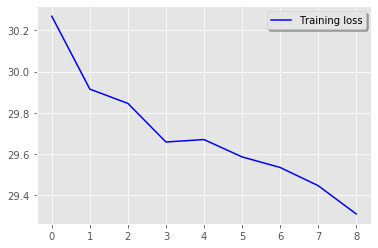

In [17]:
# Plot the loss curves for training
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [18]:
# creating submission file 
submission_pfs = model_lstm.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('submission_files/sub_relu_no_encoding.csv',index = False)

In [19]:
submission.head(3)

,ID,item_cnt_month
0,0,0.474394
1,1,0.157073
2,2,0.743292


In [20]:
submission.shape, test.shape

((214200, 2), (214200, 3))